In [1]:
import warnings
warnings.filterwarnings("ignore") 

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.style.use("/home1/smaruj/akitaX1-analyses/figures/plot_styles/global_plotting_style.mplstyle")
from scipy import stats
from cooltools.lib import numutils

from akita_utils.format_io import h5_to_df
from akita_utils.tsv_utils import filter_dataframe_by_column

from helper import read_multi_model_single_flanks_data

### Reading dingle-insertion data

In [2]:
data_dir = "/project/fudenber_735/akitaX1_analyses_data/virtual_insertion_flanks/single_insertion_flanks"
df = read_multi_model_single_flanks_data(data_dir)

In [3]:
# splitting the data into 5 groups
# group 4 is the stronges, group 0 the weakest
df_split_SCDins = df.sort_values(by='insertion_SCD').reset_index(drop=True)
df_split_SCDins.loc[:249, 'insSCD_group'] = 'Group_0'

total_rows = len(df_split_SCDins) - 250
rows_per_group = total_rows // 4

for i, group in enumerate(['Group_1', 'Group_2', 'Group_3', 'Group_4'], start=1):
    start_idx = 250 + (i - 1) * rows_per_group
    end_idx = start_idx + rows_per_group
    df_split_SCDins.loc[start_idx:end_idx, 'insSCD_group'] = group

df_split_SCDins.loc[250 + 3 * rows_per_group:, 'insSCD_group'] = 'Group_4'

flank_df = df_split_SCDins.groupby(["insSCD_group", "flank_bp"]).agg({"SCD": "mean"}).reset_index()

color_dict = {"Group_0": "#9fc2e0",
              "Group_1": "#6da3d0",
              "Group_2":"#3b7fb9", 
              "Group_3":"#2d618e", 
              "Group_4":"#1d3f5c"}

### Plot with sites splited into 5 groups by percentiles (insertion score)

Text(0, 0.5, 'Insertion Score')

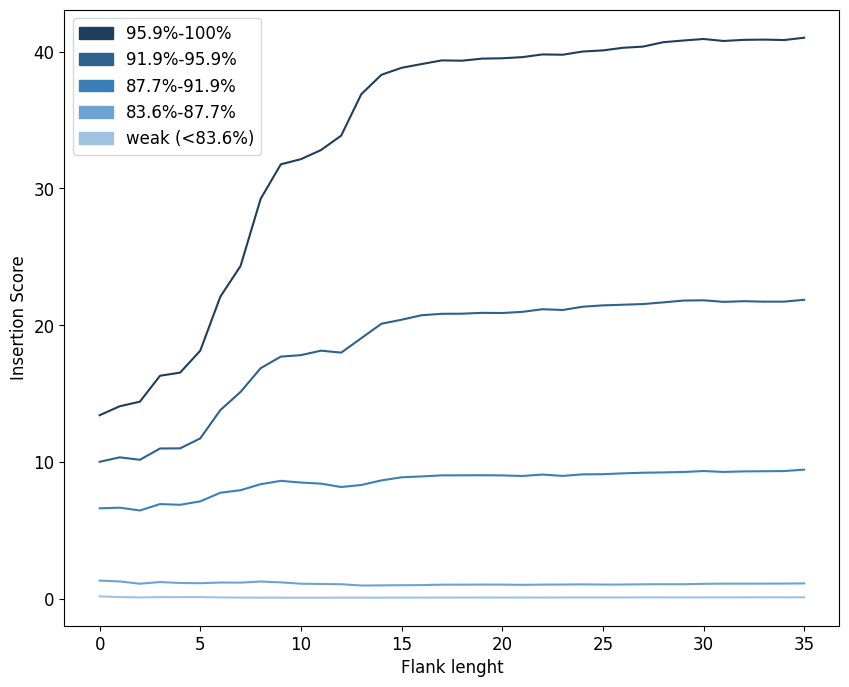

In [7]:
plt.figure(figsize=(10,8))
x = [x for x in range(36)]

for group in flank_df.insSCD_group.unique():
    plt.plot(x, flank_df[(flank_df["insSCD_group"] == group)]["SCD"], 
             c=color_dict[group])

gr4_patch = mpatches.Patch(color="#1d3f5c", label="95.9%-100%")
gr3_patch = mpatches.Patch(color="#2d618e", label="91.9%-95.9%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="87.7%-91.9%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="83.6%-87.7%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="weak (<83.6%)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Flank lenght")
plt.ylabel("Insertion Score")

### As above, with smoothed lines

In [5]:
bin_size = 11

Text(0, 0.5, 'Insertion Score')

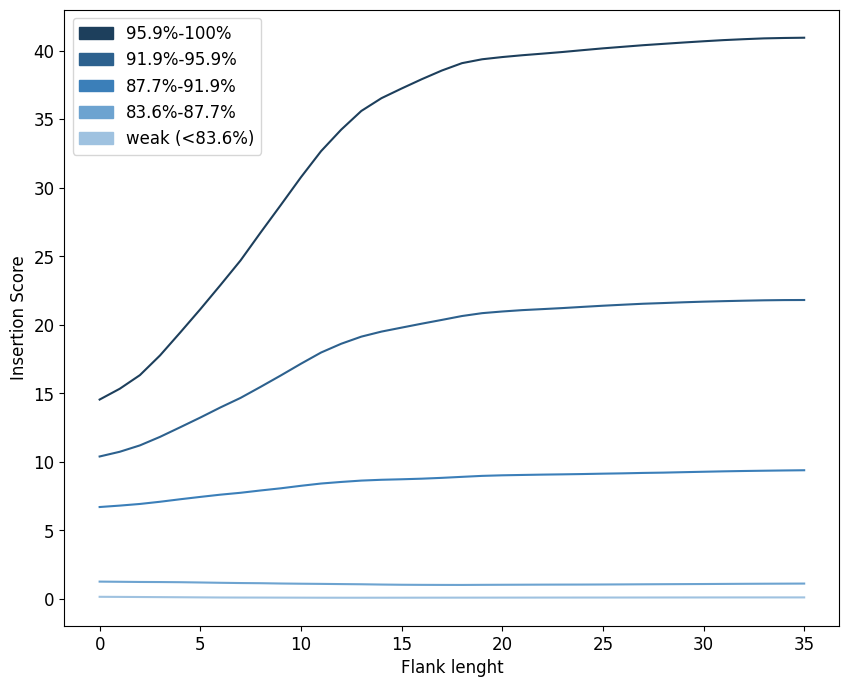

In [8]:
plt.figure(figsize=(10,8))
x = [x for x in range(36)]

for group in flank_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(flank_df[(flank_df["insSCD_group"] == group)]["SCD"], bin_size), 
             c=color_dict[group])

gr4_patch = mpatches.Patch(color="#1d3f5c", label="95.9%-100%")
gr3_patch = mpatches.Patch(color="#2d618e", label="91.9%-95.9%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="87.7%-91.9%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="83.6%-87.7%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="weak (<83.6%)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Flank lenght")
plt.ylabel("Insertion Score")

### As above, with smoothed lines and 25-75 percentile bands

In [9]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

In [10]:
insSCDpercentiles_df = df_split_SCDins.groupby(["insSCD_group", "flank_bp"])["SCD"].agg(
    percentile25 = percentile(25), percentile75 = percentile(75)).reset_index()

Text(0, 0.5, 'Insertion Score')

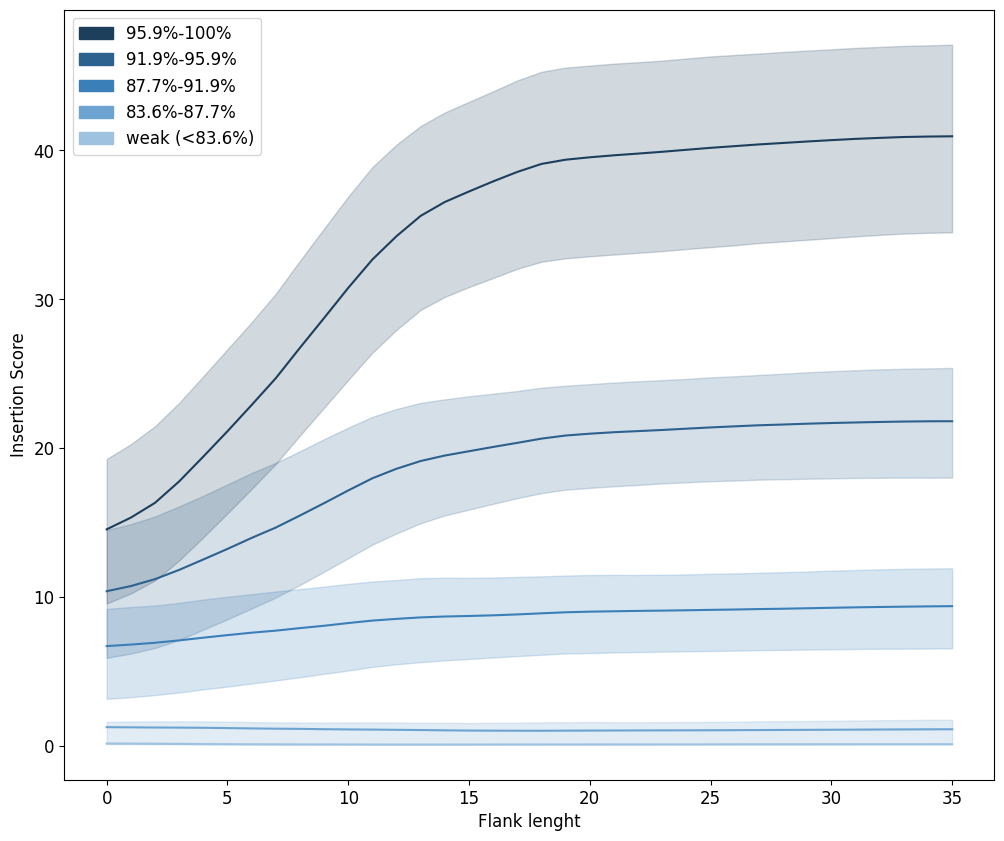

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
x = [x for x in range(36)]

for group in flank_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(flank_df[(flank_df["insSCD_group"] == group)]["SCD"], bin_size),
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

gr4_patch = mpatches.Patch(color="#1d3f5c", label="95.9%-100%")
gr3_patch = mpatches.Patch(color="#2d618e", label="91.9%-95.9%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="87.7%-91.9%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="83.6%-87.7%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="weak (<83.6%)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Flank lenght")
plt.ylabel("Insertion Score")

### Plotting 10 random sites from high, medium, low insertion_SCD group

In [16]:
num_sites = 10
ten_high = np.random.choice(df_split_SCDins[df_split_SCDins["insSCD_group"] == "Group_4"].start.unique(), size=num_sites)
ten_medium = np.random.choice(df_split_SCDins[df_split_SCDins["insSCD_group"] == "Group_2"].start.unique(), size=num_sites)
ten_low = np.random.choice(df_split_SCDins[df_split_SCDins["insSCD_group"] == "Group_0"].start.unique(), size=num_sites)

In [17]:
to_plot = df_split_SCDins[df_split_SCDins["start"].isin(ten_high)][["chrom", "end", "start", "strand"]].drop_duplicates().reset_index(drop=True)

In [18]:
# to_plot.to_csv("random_10sites_top_class.tsv", sep="\t", index=False, header=True)

Text(0, 0.5, 'Insertion Score')

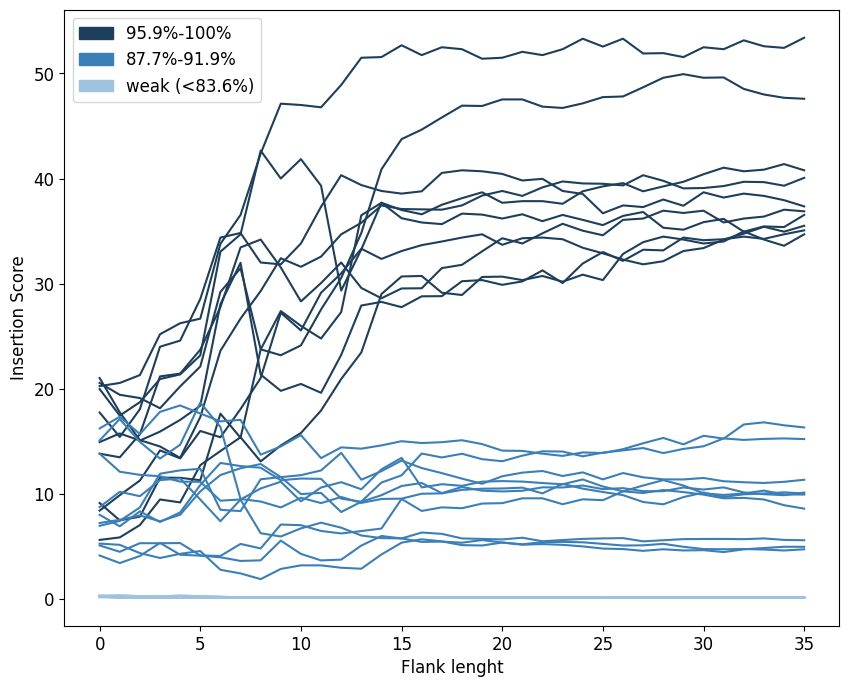

In [19]:
plt.figure(figsize=(10,8))
x = [x for x in range(36)]

for start_pos in ten_high:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="flank_bp")["SCD"], color="#1d3f5c")

for start_pos in ten_medium:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="flank_bp")["SCD"], color="#3b7fb9")

for start_pos in ten_low:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="flank_bp")["SCD"], color="#9fc2e0")

gr4_patch = mpatches.Patch(color="#1d3f5c", label="95.9%-100%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="87.7%-91.9%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="weak (<83.6%)")
plt.legend(handles=[gr4_patch, gr2_patch, gr0_patch], loc="upper left")

plt.xlabel("Flank lenght")
plt.ylabel("Insertion Score")

### As above, with smoothed trends of 5 classes overlayed with 10 lines randomly chosen from the 'High'

Text(0, 0.5, 'Insertion Score')

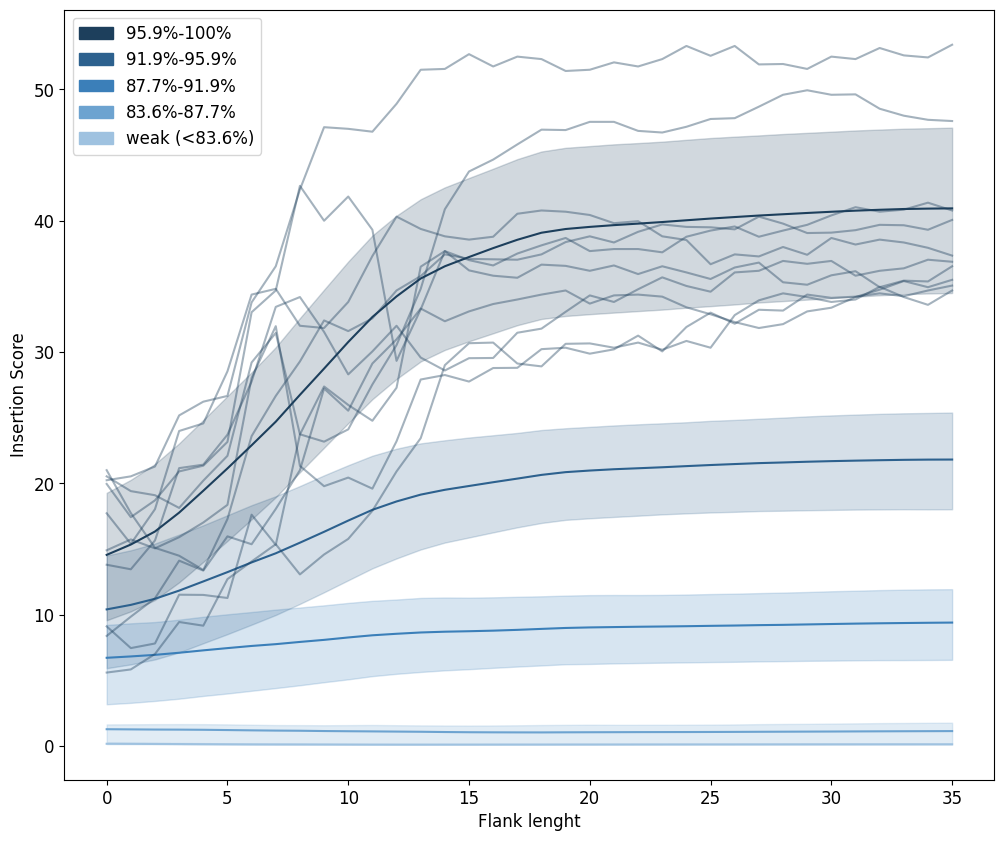

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12,10))
x = [x for x in range(36)]

for group in flank_df.insSCD_group.unique():
    plt.plot(x, numutils.smooth(flank_df[(flank_df["insSCD_group"] == group)]["SCD"], bin_size),
             c=color_dict[group])

    percentile25_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile25"], bin_size)
    percentile75_line = numutils.smooth(insSCDpercentiles_df[insSCDpercentiles_df["insSCD_group"] == group]["percentile75"], bin_size)

    ax.fill_between(x, percentile25_line, 
                    percentile75_line, alpha=0.20, color=color_dict[group])   

for start_pos in ten_high:
    plt.plot(x, df_split_SCDins[(df_split_SCDins["start"] == start_pos)].sort_values(by="flank_bp")["SCD"], color="#1d3f5c", alpha=0.4)

gr4_patch = mpatches.Patch(color="#1d3f5c", label="95.9%-100%")
gr3_patch = mpatches.Patch(color="#2d618e", label="91.9%-95.9%")
gr2_patch = mpatches.Patch(color="#3b7fb9", label="87.7%-91.9%")
gr1_patch = mpatches.Patch(color="#6da3d0", label="83.6%-87.7%")
gr0_patch = mpatches.Patch(color="#9fc2e0", label="weak (<83.6%)")
plt.legend(handles=[gr4_patch, gr3_patch, gr2_patch, gr1_patch, gr0_patch], loc="upper left")

plt.xlabel("Flank lenght")
plt.ylabel("Insertion Score")
# plt.savefig("./plots/single_insertion_flank_length_vs_indertion_score_2.pdf", format="pdf", bbox_inches="tight")